___
# Report classification using automatically extracted features
___

In [1]:
import numpy as np
import pandas as pd
from utils.dataset import labels2cat
from utils import text, dev, eval_ml, prod

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

___
# Data preparation

In [2]:
# Load the development set
df = pd.read_csv("../datasets/reports_dev.csv")

# Rename label column
df.rename(columns={'y_report': 'y'}, inplace=True)

# Convert labels to categorical
df.y = labels2cat(df.y)

# Clean text
df['clean_text'] = df.order_results.apply(text.clean_text)

# Extract information
detected_concepts = dev.extract_cv(df)

# Define features
feature_names = prod.get_feature_names(['concepts', 'composite'])
feature_names.remove('SampleType')
feature_names.remove('positive')
# feature_names.remove('equivocal')
feature_names.remove('negative')

# Define features and labels
X = text.get_concept_counts(df.histopathology_id, feature_names, detected_concepts)
y = df.y.cat.codes
groups = df.patient_id

print("Using %d features." % X.shape[1])

df.y.value_counts()

Number of unique tokens in each category: [34, 58, 14, 21, 13, 44, 34, 6, 10]
Number of unique tokens in each category after expanding: [34, 58, 14, 22, 13, 44, 34, 6, 10]
Number of unique tokens in each termset: [28, 6, 28, 6]
Number of unique tokens in each category: [32, 50, 14, 18, 12, 43, 32, 4, 10]
Number of unique tokens in each category after expanding: [32, 50, 14, 21, 12, 43, 32, 4, 10]
Number of unique tokens in each termset: [26, 6, 26, 6]
Number of unique tokens in each category: [31, 59, 14, 21, 12, 43, 34, 6, 8]
Number of unique tokens in each category after expanding: [31, 59, 14, 22, 12, 43, 34, 6, 8]
Number of unique tokens in each termset: [28, 5, 28, 5]
Number of unique tokens in each category: [29, 57, 13, 21, 12, 40, 33, 6, 10]
Number of unique tokens in each category after expanding: [29, 57, 13, 22, 12, 40, 33, 6, 10]
Number of unique tokens in each termset: [27, 6, 27, 6]
Number of unique tokens in each category: [30, 55, 14, 17, 12, 39, 31, 6, 10]
Number of un

y
Negative    199
Positive     32
Name: count, dtype: int64

In [3]:
# # List all the tokens tagged as Fungus/FungalDescriptor concepts 
# fungal_concepts = ['FungalDescriptor', 'affirmedFungalDescriptor', 'negatedFungalDescriptor',
#                    'Fungus', 'affirmedFungus', 'negatedFungus']
# fungal_concepts_tokens = [f + '_tokens' for f in fungal_concepts]
# df[fungal_concepts_tokens] = df.doc.apply(utils.doc2tokens, 
#                                           feature_names=fungal_concepts)

# # Check if all non-negated FungalDescriptor concepts are generic
# df['generic_nonneg_fung_desc'] = df.doc.apply(utils.check_generic_nonneg_fung_desc)

# # Check if all Fungus concepts are Candida 
# df['fungus_candida'] = df.doc.apply(utils.check_fungus_candida)

___
# Model selection
### Quick&dirty trying a few algorithms

In [4]:
clfs = (
    LogisticRegression(solver='lbfgs', max_iter=1000, class_weight="balanced", random_state=42),
    MultinomialNB(),
)

for clf in clfs:
    dev.score_cv(clf, X, y, groups)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
train time: 9.498s
Average precision score: 0.977 (+/- 0.06)
ROC AUC score: 0.995 (+/- 0.01)

________________________________________________________________________________
Training with 10-fold cross-validation:
MultinomialNB()
train time: 0.462s
Average precision score: 0.842 (+/- 0.31)
ROC AUC score: 0.868 (+/- 0.30)



### Tune the final model

In [5]:
clf = LogisticRegression(solver='saga', penalty='elasticnet', 
                         max_iter=5000, class_weight='balanced', random_state=42)

c = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
l1_ratio = [1.0, 0.75, 0.5, 0.25, 0.0]
param_grid = {
    'C': c, 
    'l1_ratio': l1_ratio,
}

best_params = dev.search_params(clf, 'grid', param_grid, X, y, groups)
best_model = clf.set_params(**best_params)

Best for current fold: 1.000 using {'C': 0.25, 'l1_ratio': 1.0}
0.136 (+/- 0.069) with: {'C': 1e-05, 'l1_ratio': 1.0}
0.136 (+/- 0.069) with: {'C': 1e-05, 'l1_ratio': 0.75}
0.136 (+/- 0.069) with: {'C': 1e-05, 'l1_ratio': 0.5}
0.136 (+/- 0.069) with: {'C': 1e-05, 'l1_ratio': 0.25}
0.846 (+/- 0.175) with: {'C': 1e-05, 'l1_ratio': 0.0}
0.136 (+/- 0.069) with: {'C': 0.0001, 'l1_ratio': 1.0}
0.136 (+/- 0.069) with: {'C': 0.0001, 'l1_ratio': 0.75}
0.136 (+/- 0.069) with: {'C': 0.0001, 'l1_ratio': 0.5}
0.136 (+/- 0.069) with: {'C': 0.0001, 'l1_ratio': 0.25}
0.901 (+/- 0.132) with: {'C': 0.0001, 'l1_ratio': 0.0}
0.136 (+/- 0.069) with: {'C': 0.001, 'l1_ratio': 1.0}
0.136 (+/- 0.069) with: {'C': 0.001, 'l1_ratio': 0.75}
0.136 (+/- 0.069) with: {'C': 0.001, 'l1_ratio': 0.5}
0.136 (+/- 0.069) with: {'C': 0.001, 'l1_ratio': 0.25}
0.916 (+/- 0.113) with: {'C': 0.001, 'l1_ratio': 0.0}
0.789 (+/- 0.206) with: {'C': 0.01, 'l1_ratio': 1.0}
0.789 (+/- 0.206) with: {'C': 0.01, 'l1_ratio': 0.75}
0.793 (+

In [6]:
# best_model =  LogisticRegression(solver='saga', penalty='elasticnet', 
#                                  max_iter=5000, class_weight='balanced', random_state=42, 
#                                  C=0.25, l1_ratio=1.0)

___
# Model evaluation
### Evaluate the final model using CV

In [7]:
# Model performance in each CV fold
dev.score_cv(best_model, X, y, groups)

# Make predictions for each CV fold
y_proba = dev.predict_cv(best_model, X, y, groups)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(C=0.25, class_weight='balanced', l1_ratio=1.0, max_iter=5000,
                   penalty='elasticnet', random_state=42, solver='saga')
train time: 0.075s
Average precision score: 1.000 (+/- 0.00)
ROC AUC score: 1.000 (+/- 0.00)



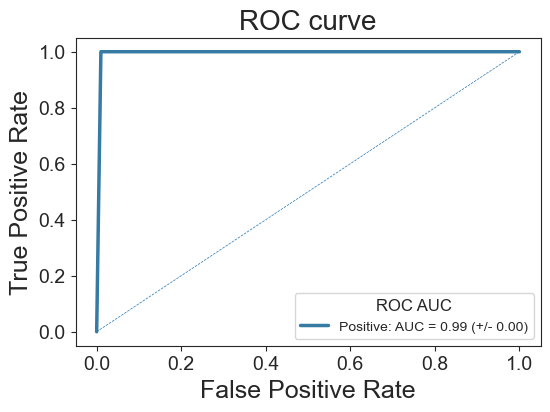

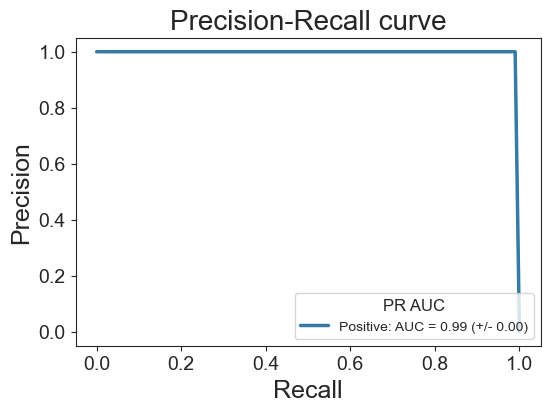

In [8]:
# Plot PR/ROC curves for each CV fold
eval_ml.plot_diagnostic_curves(df.set_index(['histopathology_id', 'val_fold']).y, y_proba, filename="auto_cv")

In [9]:
# Print optimal thresholds for each CV fold
dev.thresholds_cv(df.set_index('val_fold').y, y_proba[:,1])

# Find the optimal threshold using aggregated predictions
thresh = dev.find_optimal_threshold(y, y_proba[:,1])

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.994, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.981, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.962, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.190, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.997, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.737, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.735, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.759, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.986, F1-score = 1.000

The threshold optimises F1-score calculated from the PR

Proportion of labels predicted as:
Negative    0.87
Positive    0.13
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99       199
    Positive       0.97      0.91      0.94        32

    accuracy                           0.98       231
   macro avg       0.98      0.95      0.96       231
weighted avg       0.98      0.98      0.98       231

PPV: 0.97, Sensitivity: 0.91, Specificity: 0.99


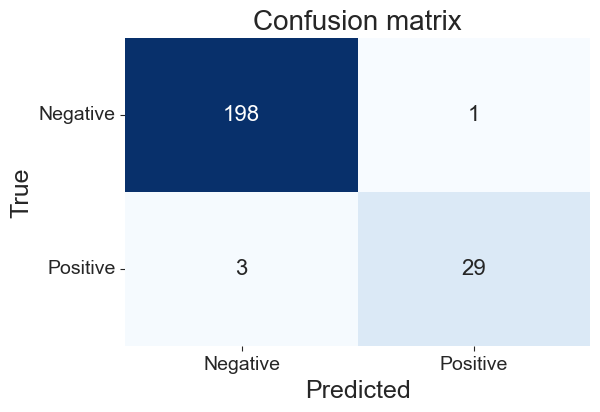

In [10]:
# Convert probabilities to class labels
y_pred = prod.proba2class(y_proba, thresh)

# Evaluate classification using aggregated predictions
eval_ml.evaluate_classification(df.y, y_pred)

In [11]:
# # Update predictions based on modification #1
# df['prediction_mod1'] = df.apply(utils.modification1, axis=1)

# # Evaluate classification using aggregated predictions
# devutils.evaluate_classification(y, df.prediction_mod1, filename="auto_cv_mod1")

### Train the final model on the full development set

In [12]:
# Learn vocabulary and termsets from the development set
vocab = text.learn_vocab(df.histopathology_id, expand=True)
termset = text.learn_termset(df.histopathology_id)

# Load NLP pipeline
nlp = text.build_nlp_pipeline(termset)

# Match phrases in text to detect concepts
df['doc'] = text.detect_concepts(df.clean_text, nlp, vocab)

# Transform predictions to a table of concepts
detected_concepts = text.get_concepts(df)

Number of unique tokens in each category: [34, 60, 14, 21, 13, 44, 34, 6, 10]
Number of unique tokens in each category after expanding: [34, 60, 14, 22, 13, 44, 34, 6, 10]
Number of unique tokens in each termset: [28, 6, 28, 6]


In [13]:
# Re-train the final model on the full development set
X = text.get_concept_counts(df.histopathology_id, feature_names, detected_concepts)

# Fit the model
best_model.fit(X, y)

LogisticRegression(C=0.25, class_weight='balanced', l1_ratio=1.0, max_iter=5000,
                   penalty='elasticnet', random_state=42, solver='saga')

### Examine model coefficients

In [14]:
intercept = best_model.intercept_
coefs = best_model.coef_[0]
null_coef = (coefs == 0).sum()
print("The intercept = %.2f." % intercept[0])
print("%d coefficients are set to 0.0, %d features remaining:" % (null_coef, len(feature_names) - null_coef))
for ft, w in zip(feature_names, coefs):
    print('{0:30}  {1}'.format(ft, w.round(2)))

The intercept = -2.42.
9 coefficients are set to 0.0, 5 features remaining:
ClinicalQuery                   0.0
FungalDescriptor                1.83
Fungus                          0.94
Invasiveness                    0.0
Stain                           0.0
equivocal                       -0.32
affirmed_FungalDescriptor       0.0
affirmed_Fungus                 0.0
affirmed_Invasiveness           0.0
affirmed_Stain                  0.13
negated_FungalDescriptor        -2.62
negated_Fungus                  0.0
negated_Invasiveness            0.0
negated_Stain                   0.0


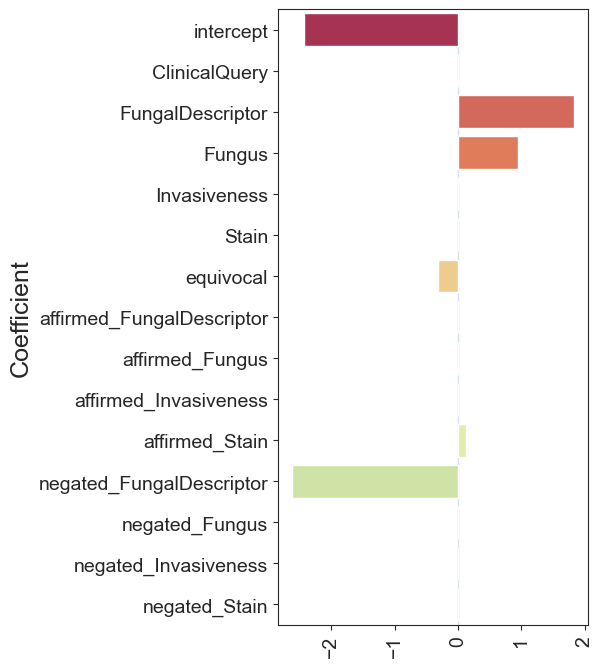

In [15]:
eval_ml.plot_coefficients(intercept, coefs, feature_names, filename="auto")

___
# Test the final model on test data

In [16]:
# Load the test set
df_test = pd.read_csv("../datasets/reports_test.csv")

# Rename label column
df_test.rename(columns={'y_report': 'y'}, inplace=True)

# Convert labels to categorical
df_test.y = labels2cat(df_test.y)

# Clean text
df_test['clean_text'] = df_test.order_results.apply(text.clean_text)

# Match phrases in text to detect concepts
df_test['doc'] = text.detect_concepts(df_test.clean_text, nlp, vocab)

# Transform predictions to a table of concepts
detected_concepts = text.get_concepts(df_test)

# Define test set features and labels
X_test = text.get_concept_counts(df_test.histopathology_id, feature_names, detected_concepts)
y_test = df_test.y.cat.codes

df_test.y.value_counts()

y
Negative    44
Positive     8
Name: count, dtype: int64

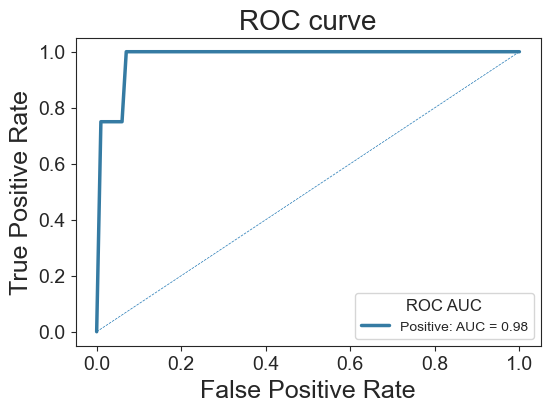

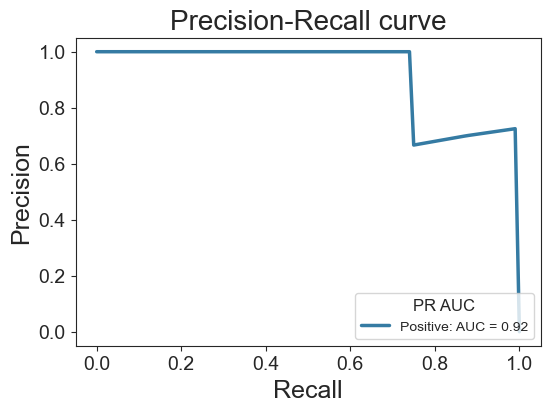

In [17]:
# Make predictions
y_proba = best_model.predict_proba(X_test)

# Plot curves
eval_ml.plot_diagnostic_curves(df_test.set_index(['histopathology_id', 'val_fold']).y,
                               y_proba, filename="auto_test")

Proportion of labels predicted as:
Negative    0.81
Positive    0.19
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

    Negative       0.98      0.93      0.95        44
    Positive       0.70      0.88      0.78         8

    accuracy                           0.92        52
   macro avg       0.84      0.90      0.87        52
weighted avg       0.93      0.92      0.93        52

PPV: 0.70, Sensitivity: 0.88, Specificity: 0.93


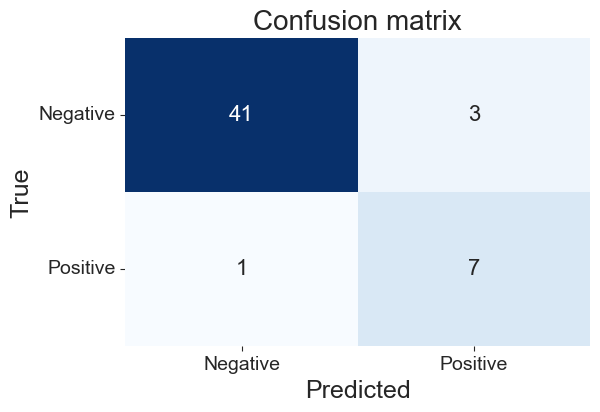

In [19]:
# Convert probabilities to class labels
y_pred = prod.proba2class(y_proba, thresh)

# Evaluate classification
eval_ml.evaluate_classification(df_test.y, y_pred, filename="auto_test")

In [ ]:
# # List all the tokens tagged as Fungus/FungalDescriptor concepts 
# fungal_concepts = ['FungalDescriptor', 'affirmedFungalDescriptor', 'negatedFungalDescriptor',
#                    'Fungus', 'affirmedFungus', 'negatedFungus']
# fungal_concepts_tokens = [f + '_tokens' for f in fungal_concepts]
# df_test[fungal_concepts_tokens] = df_test.doc.apply(utils.doc2tokens, 
#                                                     feature_names=fungal_concepts)

# # Check if all non-negated FungalDescriptor concepts are generic
# df_test['generic_nonneg_fung_desc'] = df_test.doc.apply(utils.check_generic_nonneg_fung_desc)

# # Check if all Fungus concepts are Candida 
# df_test['fungus_candida'] = df_test.doc.apply(utils.check_fungus_candida)

# Update predictions based on modification #1
# df_test['prediction_mod1'] = df_test.apply(utils.modification1, axis=1)

___
## Save the final model, the vocabulary and the threshold value

In [20]:
import pickle 

with open("../models/classifier_dev.sav", 'wb') as f:
    pickle.dump(best_model, f)
with open("../models/vocab_dev.sav", 'wb') as f:
    pickle.dump(vocab, f)   
with open("../models/termset_dev.sav", 'wb') as f:
    pickle.dump(termset, f) 
with open("../models/thresh_dev.txt", 'w') as f:
    f.write(str(thresh))  